In [1]:
import pandas as pd

# Cargar product_id_apredecir201912.txt
df_ids = pd.read_csv('product_id_apredecir201912.txt')
df_ids.head()

,product_id
0,20001
1,20002
2,20003
3,20004
4,20005


In [2]:
# Cargar sell-in.txt (puede ser un archivo grande, leer solo columnas necesarias)
sellin_cols = ['periodo', 'customer_id', 'product_id', 'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn', 'tn']
df_sellin = pd.read_csv('sell-in.txt', sep='\t', usecols=sellin_cols)
df_sellin.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [3]:
# Contar valores únicos de customer_id
df_sellin['customer_id'].nunique()
# Contar valores únicos de product_id
#df_sellin['product_id'].nunique()
# Contar valores únicos de periodo
#df_sellin['periodo'].nunique()


597

In [4]:
# Merge de ambos dataframes por product_id
#df_merged = pd.merge(df_sellin, df_ids, on='product_id', how='inner')
#df_merged.head()

In [5]:
# Si 'periodo' es tipo string o int, conviértelo a datetime para mayor facilidad
df_sellin['periodo'] = pd.to_datetime(df_sellin['periodo'], format='%Y%m')
df_sellin= df_sellin.sort_values(['product_id', 'customer_id', 'periodo']).reset_index(drop=True)


Hacer el producto cartesiano de producto-cliente-período y agregar 0s.

In [6]:
# 1. Listas de valores únicos
product_ids = df_sellin['product_id'].unique()
customer_ids = df_sellin['customer_id'].unique()
periodos = pd.date_range(
    start=df_sellin['periodo'].min(), 
    end=df_sellin['periodo'].max(), 
    freq='MS'  # Monthly start frequency
)

# 2. Producto cartesiano
cartesian = pd.MultiIndex.from_product(
    [product_ids, customer_ids, periodos], 
    names=['product_id', 'customer_id', 'periodo']
).to_frame(index=False)

In [7]:
# 3. Filtrar productos activos
periodo_producto = df_sellin.groupby('product_id')['periodo'].agg(['min', 'max']).reset_index()
periodo_producto.columns = ['product_id', 'periodo_min_producto', 'periodo_max_producto']

# 4. Filtrar clientes activos
periodo_customer = df_sellin.groupby('customer_id')['periodo'].agg(['min', 'max']).reset_index()
periodo_customer.columns = ['customer_id', 'periodo_min_customer', 'periodo_max_customer']

In [8]:
# 5. Merge para filtrar combinaciones válidas
cartesian = cartesian.merge(periodo_producto, on='product_id', how='left')
cartesian = cartesian.merge(periodo_customer, on='customer_id', how='left')

# 6. Filtrar combinaciones donde el periodo esté dentro del rango activo
cartesian = cartesian[
    (cartesian['periodo'] >= cartesian['periodo_min_producto']) & 
    (cartesian['periodo'] <= cartesian['periodo_max_producto']) &
    (cartesian['periodo'] >= cartesian['periodo_min_customer']) #&
    #(cartesian['periodo'] <= cartesian['periodo_max_customer'])
].copy()

# 7. Merge con el dataset original
df_final = cartesian.merge(
    df_sellin, 
    on=['product_id', 'customer_id', 'periodo'], 
    how='left'
)

In [9]:
df_final.shape

(17173448, 11)

In [10]:
# 8. Completar las ventas y cualquier otra variable faltante con 0
df_final['tn'] = df_final['tn'].fillna(0)
df_final['plan_precios_cuidados'] = df_final['plan_precios_cuidados'].fillna(0)
df_final['cust_request_qty'] = df_final['cust_request_qty'].fillna(0)
df_final['cust_request_tn'] = df_final['cust_request_tn'].fillna(0)
# Podés extender esto a otras variables que consideres relevantes.

# 9. Revisar el resultado
print(df_final.head())

   product_id  customer_id    periodo periodo_min_producto  \
0       20001        10001 2017-01-01           2017-01-01   
1       20001        10001 2017-02-01           2017-01-01   
2       20001        10001 2017-03-01           2017-01-01   
3       20001        10001 2017-04-01           2017-01-01   
4       20001        10001 2017-05-01           2017-01-01   

  periodo_max_producto periodo_min_customer periodo_max_customer  \
0           2019-12-01           2017-01-01           2019-12-01   
1           2019-12-01           2017-01-01           2019-12-01   
2           2019-12-01           2017-01-01           2019-12-01   
3           2019-12-01           2017-01-01           2019-12-01   
4           2019-12-01           2017-01-01           2019-12-01   

   plan_precios_cuidados  cust_request_qty  cust_request_tn         tn  
0                    0.0              11.0         99.43861   99.43861  
1                    0.0              23.0        198.84365  198.84365  

Creación de variable target: tn_t_plus_2

In [11]:
# Creamos la variable objetivo: tn en t+2 para cada combinación product_id y customer_id
# df_merged['tn_t_plus_2']

# Paso 1: Crear columna con periodo +2 meses
df_final['periodo_target'] = df_final['periodo'] + pd.DateOffset(months=2)

# Paso 2: Crear DataFrame con target
target_df = df_final[['product_id', 'customer_id', 'periodo', 'tn']].copy()
target_df.rename(columns={'periodo': 'periodo_target', 'tn': 'tn_t_plus_2'}, inplace=True)

# Paso 3: Hacer el merge
df_final = df_final.merge(
    target_df,
    on=['product_id', 'customer_id', 'periodo_target'],
    how='left'
)

# Paso 4: Validar
print(df_final[['product_id', 'customer_id', 'periodo', 'tn', 'tn_t_plus_2']].head(20))




    product_id  customer_id    periodo         tn  tn_t_plus_2
0        20001        10001 2017-01-01   99.43861     92.46537
1        20001        10001 2017-02-01  198.84365     13.29728
2        20001        10001 2017-03-01   92.46537    101.00563
3        20001        10001 2017-04-01   13.29728    128.04792
4        20001        10001 2017-05-01  101.00563    101.20711
5        20001        10001 2017-06-01  128.04792     43.33930
6        20001        10001 2017-07-01  101.20711    289.35024
7        20001        10001 2017-08-01   43.33930    222.11389
8        20001        10001 2017-09-01  289.35024    111.54944
9        20001        10001 2017-10-01  222.11389    131.27150
10       20001        10001 2017-11-01  111.54944     49.61857
11       20001        10001 2017-12-01  131.27150     88.44065
12       20001        10001 2018-01-01   49.61857    214.72336
13       20001        10001 2018-02-01   88.44065    132.83419
14       20001        10001 2018-03-01  214.72336    16

In [12]:
# Eliminamos filas donde no hay target (NaN)
#df_model = df_merged.dropna(subset=['tn_t_plus_2'])

In [13]:
# Probar combinaciones de producto - cliente
df_final[(df_final['product_id'] == 20524) & (df_final['customer_id'] == 10125)].head(10)

,product_id,customer_id,periodo,periodo_min_producto,periodo_max_producto,periodo_min_customer,periodo_max_customer,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,periodo_target,tn_t_plus_2
8959408,20524,10125,2017-01-01,2017-01-01,2019-12-01,2017-01-01,2019-11-01,0.0,1.0,0.02271,0.02271,2017-03-01,0.00000
8959409,20524,10125,2017-02-01,2017-01-01,2019-12-01,2017-01-01,2019-11-01,0.0,0.0,0.00000,0.00000,2017-04-01,0.00757
8959410,20524,10125,2017-03-01,2017-01-01,2019-12-01,2017-01-01,2019-11-01,0.0,0.0,0.00000,0.00000,2017-05-01,0.00757
8959411,20524,10125,2017-04-01,2017-01-01,2019-12-01,2017-01-01,2019-11-01,0.0,1.0,0.00757,0.00757,2017-06-01,0.00000
8959412,20524,10125,2017-05-01,2017-01-01,2019-12-01,2017-01-01,2019-11-01,0.0,1.0,0.00757,0.00757,2017-07-01,0.00000
8959413,20524,10125,2017-06-01,2017-01-01,2019-12-01,2017-01-01,2019-11-01,0.0,0.0,0.00000,0.00000,2017-08-01,0.00000
8959414,20524,10125,2017-07-01,2017-01-01,2019-12-01,2017-01-01,2019-11-01,0.0,0.0,0.00000,0.00000,2017-09-01,0.00757
8959415,20524,10125,2017-08-01,2017-01-01,2019-12-01,2017-01-01,2019-11-01,0.0,0.0,0.00000,0.00000,2017-10-01,0.00757
8959416,20524,10125,2017-09-01,2017-01-01,2019-12-01,2017-01-01,2019-11-01,0.0,1.0,0.00757,0.00757,2017-11-01,0.00000
8959417,20524,10125,2017-10-01,2017-01-01,2019-12-01,2017-01-01,2019-11-01,0.0,1.0,0.00757,0.00757,2017-12-01,0.00000


Feature engeneering

In [14]:
df_full = df_final.copy()

# Elimino columnas innecesarias
df_full.drop(columns=['periodo_min_producto', 'periodo_max_producto', 'periodo_min_customer', 'periodo_max_customer', 'periodo_target'], inplace=True)
df_full.head()

,product_id,customer_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,tn_t_plus_2
0,20001,10001,2017-01-01,0.0,11.0,99.43861,99.43861,92.46537
1,20001,10001,2017-02-01,0.0,23.0,198.84365,198.84365,13.29728
2,20001,10001,2017-03-01,0.0,33.0,92.46537,92.46537,101.00563
3,20001,10001,2017-04-01,0.0,8.0,13.29728,13.29728,128.04792
4,20001,10001,2017-05-01,0.0,15.0,101.20711,101.00563,101.20711


In [15]:
df_full.shape

(17173448, 8)

1. Lags (valores previos)


In [16]:
for lag in [1, 2, 3, 4, 5, 6, 9, 10, 11, 12]:
    df_full[f'tn_lag_{lag}'] = df_full.groupby(['product_id', 'customer_id'])['tn'].shift(lag)

2. Rolling Mean (media móvil)
media de los últimos 3, 6, 9 y 12 meses:

In [ ]:
for window in [3, 6, 9, 12, 15, 18, 21, 24]:  
    df_full[f'tn_rollmean_{window}'] = (
        df_full.groupby(['product_id', 'customer_id'])['tn']
        .transform(lambda x: x.rolling(window, min_periods=1).mean())
    )

3. Rolling Sum (suma móvil)
la suma de los últimos 3 meses:

In [18]:
df_full['tn_rollsum_3'] = (
    df_full.groupby(['product_id', 'customer_id'])['tn']
    .transform(lambda x: x.rolling(3, min_periods=1).sum())
)

4. Promedio histórico por producto y cliente
Capturar el comportamiento típico de cada combinación:

In [19]:
# Promedio histórico de tn por product_id y customer_id hasta el periodo actual (excluyendo el actual)
df_full['tn_mean_hist'] = (
    df_full.groupby(['product_id', 'customer_id'])['tn']
    .transform(lambda x: x.expanding().mean().shift(1))
)

5. Lag y rolling para otras variables
Repetir la lógica para otras columnas como cust_request_qty y cust_request_tn:

In [20]:
for col in ['cust_request_qty', 'cust_request_tn']:
    for lag in [1, 2, 3]:
        df_full[f'{col}_lag_{lag}'] = df_full.groupby(['product_id', 'customer_id'])[col].shift(lag)
    df_full[f'{col}_rollmean_3'] = (
        df_full.groupby(['product_id', 'customer_id'])[col]
        .transform(lambda x: x.rolling(3, min_periods=1).mean())
    )

In [21]:
#6. Eliminar filas con NaN en features
#df_model = df_full.dropna(subset=['tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_t_plus_2'])

In [22]:
# Probar combinaciones de producto - cliente
df_full[(df_full['product_id'] == 20524) & (df_final['customer_id'] == 10125)].head(10)
#df_full.head()

,product_id,customer_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,tn_t_plus_2,tn_lag_1,tn_lag_2,...,tn_rollsum_3,tn_mean_hist,cust_request_qty_lag_1,cust_request_qty_lag_2,cust_request_qty_lag_3,cust_request_qty_rollmean_3,cust_request_tn_lag_1,cust_request_tn_lag_2,cust_request_tn_lag_3,cust_request_tn_rollmean_3
8959408,20524,10125,2017-01-01,0.0,1.0,0.02271,0.02271,0.00000,NaN,NaN,...,0.02271,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.022710
8959409,20524,10125,2017-02-01,0.0,0.0,0.00000,0.00000,0.00757,0.02271,NaN,...,0.02271,0.022710,1.0,NaN,NaN,0.500000,0.02271,NaN,NaN,0.011355
8959410,20524,10125,2017-03-01,0.0,0.0,0.00000,0.00000,0.00757,0.00000,0.02271,...,0.02271,0.011355,0.0,1.0,NaN,0.333333,0.00000,0.02271,NaN,0.007570
8959411,20524,10125,2017-04-01,0.0,1.0,0.00757,0.00757,0.00000,0.00000,0.00000,...,0.00757,0.007570,0.0,0.0,1.0,0.333333,0.00000,0.00000,0.02271,0.002523
8959412,20524,10125,2017-05-01,0.0,1.0,0.00757,0.00757,0.00000,0.00757,0.00000,...,0.01514,0.007570,1.0,0.0,0.0,0.666667,0.00757,0.00000,0.00000,0.005047
8959413,20524,10125,2017-06-01,0.0,0.0,0.00000,0.00000,0.00000,0.00757,0.00757,...,0.01514,0.007570,1.0,1.0,0.0,0.666667,0.00757,0.00757,0.00000,0.005047
8959414,20524,10125,2017-07-01,0.0,0.0,0.00000,0.00000,0.00757,0.00000,0.00757,...,0.00757,0.006308,0.0,1.0,1.0,0.333333,0.00000,0.00757,0.00757,0.002523
8959415,20524,10125,2017-08-01,0.0,0.0,0.00000,0.00000,0.00757,0.00000,0.00000,...,0.00000,0.005407,0.0,0.0,1.0,0.000000,0.00000,0.00000,0.00757,0.000000
8959416,20524,10125,2017-09-01,0.0,1.0,0.00757,0.00757,0.00000,0.00000,0.00000,...,0.00757,0.004731,0.0,0.0,0.0,0.333333,0.00000,0.00000,0.00000,0.002523
8959417,20524,10125,2017-10-01,0.0,1.0,0.00757,0.00757,0.00000,0.00757,0.00000,...,0.01514,0.005047,1.0,0.0,0.0,0.666667,0.00757,0.00000,0.00000,0.005047


Entrenamiento del modelo Light GBM

Preparar los datos de entrenamiento y test
Entrenamiento: Usa todos los datos donde tn_t_plus_2 no es NaN y el período es menor a 201912 (para no usar datos del futuro).
Test: Filtra las filas donde el período es 201912 (diciembre 2019), ya que para esas filas queremos predecir tn en 202002 (febrero 2020).

In [23]:
# Lista de features: incluye todas las columnas que empiezan con los prefijos de los features
feature_cols = [
    col for col in df_full.columns
    if (
        col.startswith('tn_lag_') or
        col.startswith('tn_roll') or
        col.startswith('cust_request_qty_lag_') or
        col.startswith('cust_request_qty_roll') or
        col.startswith('cust_request_tn_lag_') or
        col.startswith('cust_request_tn_roll') or
        col == 'plan_precios_cuidados'  
    )
]

In [24]:
# Verifico los valores de product_id = 20001 y customer_id = 10063
# train[(train['product_id'] == 20001) & (train['customer_id'] == 10063) & (train['periodo'] > pd.to_datetime('2019-01-01'))]
df_full[(df_full['product_id'] == 20064) & (df_full['customer_id'] == 10001) & (df_full['periodo'] > pd.to_datetime('2019-01-01'))]

,product_id,customer_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,tn_t_plus_2,tn_lag_1,tn_lag_2,...,tn_rollsum_3,tn_mean_hist,cust_request_qty_lag_1,cust_request_qty_lag_2,cust_request_qty_lag_3,cust_request_qty_rollmean_3,cust_request_tn_lag_1,cust_request_tn_lag_2,cust_request_tn_lag_3,cust_request_tn_rollmean_3
1203554,20064,10001,2019-02-01,0.0,4.0,3.4944,3.4944,6.4610,24.8976,10.4832,...,38.8752,10.361624,18.0,5.0,7.0,9.000000,24.8976,10.4832,8.7360,12.958400
1203555,20064,10001,2019-03-01,0.0,7.0,5.7148,5.7148,11.3568,3.4944,24.8976,...,34.1068,10.097500,4.0,18.0,5.0,9.666667,3.4944,24.8976,10.4832,11.368933
1203556,20064,10001,2019-04-01,0.0,2.0,6.4610,6.4610,6.9888,5.7148,3.4944,...,15.6702,9.935178,7.0,4.0,18.0,4.333333,5.7148,3.4944,24.8976,5.223400
1203557,20064,10001,2019-05-01,0.0,3.0,11.3568,11.3568,15.3062,6.4610,5.7148,...,23.5326,9.811100,2.0,7.0,4.0,4.000000,6.4610,5.7148,3.4944,7.844200
1203558,20064,10001,2019-06-01,0.0,5.0,6.9888,6.9888,2.8392,11.3568,6.4610,...,24.8066,9.864400,3.0,2.0,7.0,3.333333,11.3568,6.4610,5.7148,8.268867
1203559,20064,10001,2019-07-01,0.0,4.0,15.3062,15.3062,2.6208,6.9888,11.3568,...,33.6518,9.768547,5.0,3.0,2.0,4.000000,6.9888,11.3568,6.4610,11.217267
1203560,20064,10001,2019-08-01,0.0,2.0,2.8392,2.8392,9.6096,15.3062,6.9888,...,25.1342,9.947181,4.0,5.0,3.0,3.666667,15.3062,6.9888,11.3568,8.378067
1203561,20064,10001,2019-09-01,0.0,1.0,2.6208,2.6208,NaN,2.8392,15.3062,...,20.7662,9.725056,2.0,4.0,5.0,2.333333,2.8392,15.3062,6.9888,6.922067
1203562,20064,10001,2019-10-01,0.0,1.0,9.6096,9.6096,NaN,2.6208,2.8392,...,15.0696,9.509776,1.0,2.0,4.0,1.333333,2.6208,2.8392,15.3062,5.023200


In [25]:
# Entrenamiento y validación
train = df_full[df_full['periodo'] < pd.to_datetime('2019-10-01')]
train = train[train['tn_t_plus_2'].notnull()] # Filtro con target válido
valid = df_full[df_full['periodo'] == pd.to_datetime('2019-10-01')]
valid = valid[valid['tn_t_plus_2'].notnull()] # Filtro con target válido
test = df_full[df_full['periodo'] == pd.to_datetime('2019-12-01')]

X_train = train[feature_cols]
y_train = train['tn_t_plus_2']
X_valid = valid[feature_cols]
y_valid = valid['tn_t_plus_2']
X_test = test[feature_cols]

In [26]:
# Chequeo de NaNs en y_train y y_valid
print("NaNs en y_train:", y_train.isnull().sum())
print("NaNs en y_valid:", y_valid.isnull().sum())



NaNs en y_train: 0
NaNs en y_valid: 0


In [27]:
'''invalid_rows = valid[valid['tn_t_plus_2'].isnull()]


productos_con_nan_target = invalid_rows['product_id'].unique()
print("Productos con target nulo:", productos_con_nan_target)'''


'invalid_rows = valid[valid[\'tn_t_plus_2\'].isnull()]\n\n\nproductos_con_nan_target = invalid_rows[\'product_id\'].unique()\nprint("Productos con target nulo:", productos_con_nan_target)'

In [28]:

'''productos_activos = df_ids['product_id'].unique()
print("Productos activos en 2019-12:", productos_activos)'''


'productos_activos = df_ids[\'product_id\'].unique()\nprint("Productos activos en 2019-12:", productos_activos)'

In [29]:
'''df_resultado = pd.DataFrame({'product_id': productos_con_nan_target})
df_resultado['activo_en_201912'] = df_resultado['product_id'].isin(productos_activos)
print(df_resultado)'''



"df_resultado = pd.DataFrame({'product_id': productos_con_nan_target})\ndf_resultado['activo_en_201912'] = df_resultado['product_id'].isin(productos_activos)\nprint(df_resultado)"

Entrena el modelo LightGBM

In [30]:
import numpy as np
import lightgbm as lgb
import optuna


storage = optuna.storages.RDBStorage(
    url="sqlite:///optuna_study.db"
)

def total_forecast_error(y_true, y_pred):
    error_abs = np.abs(y_true - y_pred)
    return np.sum(error_abs) / np.sum(y_true)

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'mse', 
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    model = lgb.LGBMRegressor(**param)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)]
    )

    y_pred = model.predict(X_valid)
    tfe = total_forecast_error(y_valid, y_pred)
    return tfe

study2 = optuna.create_study(study_name="model_tuning",direction='minimize', storage=storage,
    load_if_exists=True)
study2.optimize(objective, n_trials=1)

print("Best params:", study2.best_params)
print("Best Total Forecast Error:", study2.best_value)


[I 2025-06-11 16:10:58,879] Using an existing study with name 'model_tuning' instead of creating a new one.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.473114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5109
[LightGBM] [Info] Number of data points in the train set: 15197117, number of used features: 24
[LightGBM] [Info] Start training from score 0.079931


[I 2025-06-11 16:12:16,619] Trial 137 finished with value: 1.0966817988038904 and parameters: {'learning_rate': 0.0720981537623799, 'num_leaves': 29, 'max_depth': 13, 'subsample': 0.6395523697013361, 'colsample_bytree': 0.5478199786444611}. Best is trial 136 with value: 0.862806847784841.


Best params: {'learning_rate': 0.07905132294070043, 'num_leaves': 29, 'max_depth': 13, 'subsample': 0.6262454327760815, 'colsample_bytree': 0.5136598902019459}
Best Total Forecast Error: 0.862806847784841


In [31]:
import optuna.visualization as vis

vis.plot_optimization_history(study2)


In [32]:
best_params = study2.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'mse'
best_params['n_estimators'] = 1000

final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(
    pd.concat([X_train, X_valid]), 
    pd.concat([y_train, y_valid])
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.310630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5106
[LightGBM] [Info] Number of data points in the train set: 15741687, number of used features: 24
[LightGBM] [Info] Start training from score 0.078829


LGBMRegressor(colsample_bytree=0.5136598902019459,
              learning_rate=0.07905132294070043, max_depth=13, metric='mse',
              n_estimators=1000, num_leaves=29, objective='regression',
              subsample=0.6262454327760815)

Feature importance

In [33]:

# Obtener la importancia de las variables
importancias = final_model.feature_importances_

# Crear un DataFrame ordenado
df_importancia = pd.DataFrame({
    'feature': feature_cols,
    'importance': importancias
}).sort_values(by='importance', ascending=False)

# Mostrar las 20 más importantes
print(df_importancia.head(20))

                        feature  importance
19  cust_request_qty_rollmean_3        3245
18       cust_request_qty_lag_3        2486
17       cust_request_qty_lag_2        2453
16       cust_request_qty_lag_1        2361
4                      tn_lag_4        1497
7                      tn_lag_9        1493
6                      tn_lag_6        1410
5                      tn_lag_5        1333
8                     tn_lag_10        1300
10                    tn_lag_12        1267
9                     tn_lag_11        1245
3                      tn_lag_3        1133
1                      tn_lag_1        1071
2                      tn_lag_2        1061
20        cust_request_tn_lag_1         957
22        cust_request_tn_lag_3         888
21        cust_request_tn_lag_2         859
15                 tn_rollsum_3         389
11                tn_rollmean_3         362
23   cust_request_tn_rollmean_3         322


In [34]:
import plotly.express as px
# Ordenar descendente y mostrar todas las features
df_importancia_sorted = df_importancia.sort_values(by='importance', ascending=True)
fig = px.bar(
    df_importancia_sorted,
    x='importance',
    y='feature',
    orientation='h',
    title='Feature Importance - LightGBM',
)
fig.update_layout(height=600)
fig.show()



In [35]:
#pip install shap

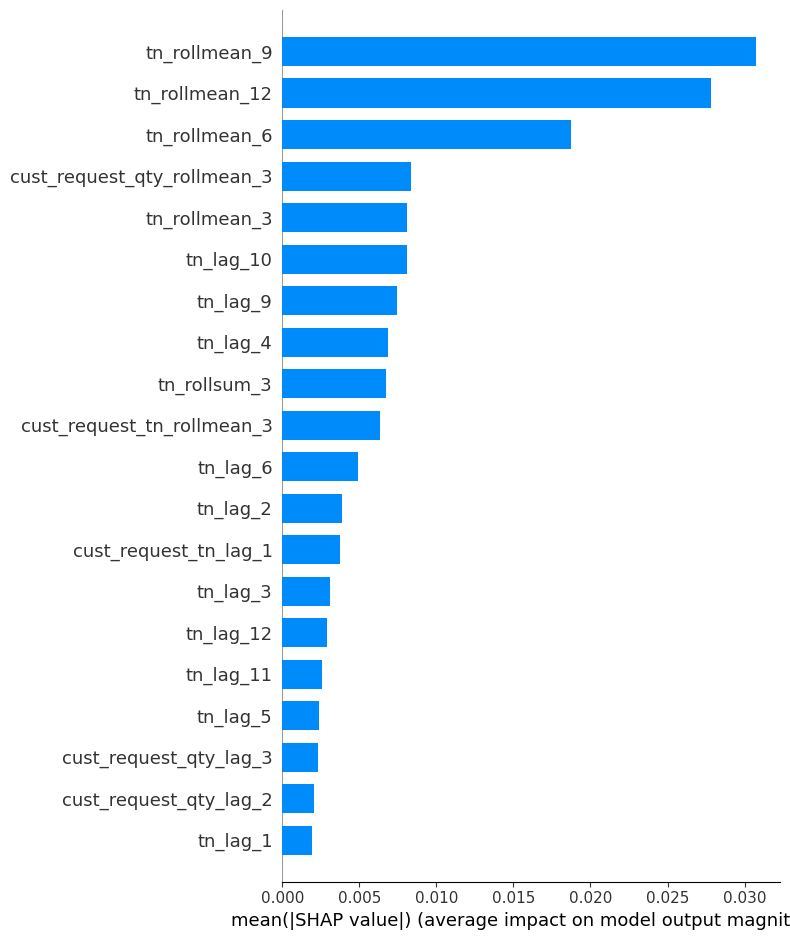

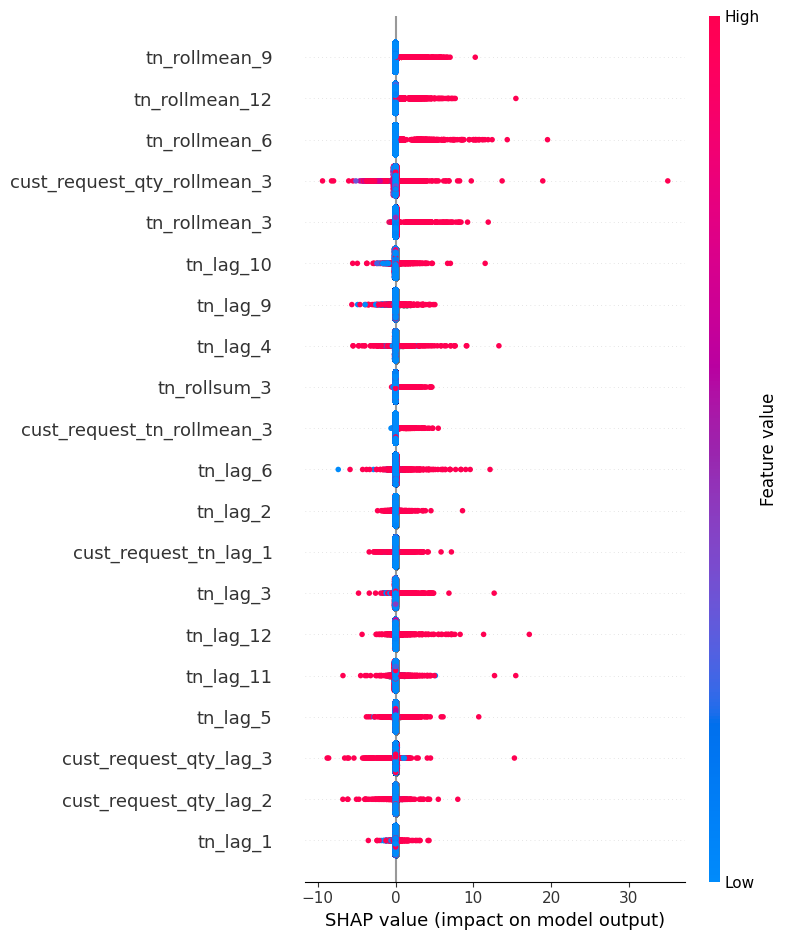

In [36]:
import shap

# Explicador para modelos de LightGBM
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# Resumen global de importancia (barplot)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Resumen detallado (beeswarm)
shap.summary_plot(shap_values, X_test)

Predicciones para febrero 2020

In [37]:
# Predicciones
test['tn_pred_202002'] = final_model.predict(X_test)



/var/folders/jc/2ck28b4s2s96h7nsbqgph0zh0000gn/T/ipykernel_3027/1582821623.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Archivo para Kaggle

In [38]:
# Ensamble
# Cargar promedio ult 12M *0,98
df_prom = pd.read_csv('Prom12M098.csv')
#df_prom.head()
df_prom.shape

(780, 2)

In [39]:
# Agregar por product_id
submission_agg = test.groupby('product_id')['tn_pred_202002'].sum().reset_index()

# Renombrar 
submission_agg.rename(columns={'tn_pred_202002': 'tn'}, inplace=True)

# Merge con dataframe ids por product_id
submission_agg2 = pd.merge(submission_agg, df_ids, on='product_id', how='inner')
submission_agg3 = submission_agg2.copy()
#submission_agg2.head()
#submission_agg2.shape

# Hago el promedio para el ensamble
submission_agg3['tn'] = (df_prom['tn'] + submission_agg3['tn']) / 2
#submission_agg2.head()

# Exportar a CSV LightGBM & Ensamble
submission_agg2.to_csv('submission.csv', index=False)
submission_agg3.to_csv('submission_e.csv', index=False)

----

df_full 2019 12 - predicción vs realidad

In [40]:
# df_full 2019 12 - predicción vs realidad

df_real = df_full[(df_full['periodo'] == pd.to_datetime('2019-12-01'))]

# Agregar por product_id
df_real = df_real.groupby('product_id')['tn'].sum().reset_index()

df_real.head()

,product_id,tn
0,20001,1504.68856
1,20002,1087.30855
2,20003,892.50129
3,20004,637.90002
4,20005,593.24443


In [41]:
# Merge con dataframe por product_id
df_real = pd.merge(df_real, submission_agg2, on='product_id', how='inner')

df_real.head()

,product_id,tn_x,tn_y
0,20001,1504.68856,1133.409448
1,20002,1087.30855,822.800399
2,20003,892.50129,661.516040
3,20004,637.90002,545.372065
4,20005,593.24443,566.507833


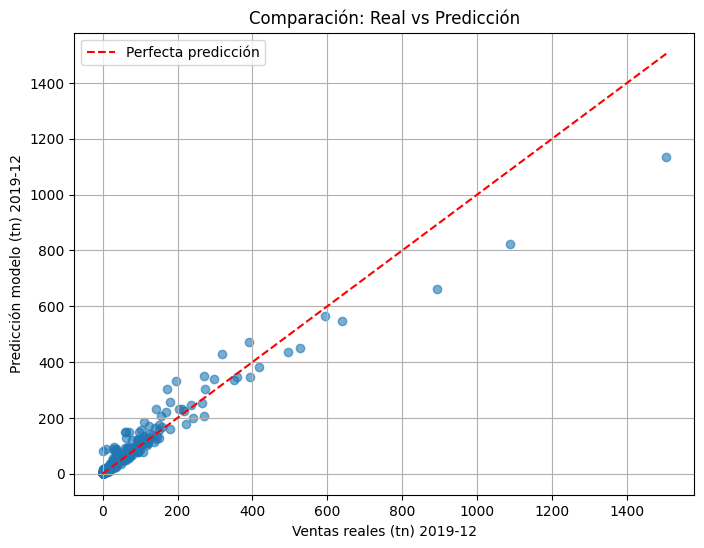

In [42]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.scatter(df_real['tn_x'], df_real['tn_y'], alpha=0.6)
plt.plot([df_real['tn_x'].min(), df_real['tn_x'].max()],
         [df_real['tn_x'].min(), df_real['tn_x'].max()],
         'r--', label='Perfecta predicción')
plt.xlabel('Ventas reales (tn) 2019-12')
plt.ylabel('Predicción modelo (tn) 2019-12')
plt.title('Comparación: Real vs Predicción')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
import plotly.express as px

fig = px.scatter(
    df_real,
    x='tn_x',
    y='tn_y',
    hover_data=['product_id'],
    labels={
        'tn_x': 'Ventas reales (tn) 2019-12',
        'tn_y': 'Predicción modelo (tn) 2019-12'
    },
    title='Comparación: Real vs Predicción (por producto)'
)

# Línea de referencia de predicción perfecta
fig.add_shape(
    type='line',
    x0=df_real['tn_x'].min(), y0=df_real['tn_x'].min(),
    x1=df_real['tn_x'].max(), y1=df_real['tn_x'].max(),
    line=dict(color='red', dash='dash'),
    name='Perfecta predicción'
)

fig.show()

In [48]:
df_real['real-pred'] = df_real['tn_x'] - df_real['tn_y']
df_real['err_abs'] = (df_real['tn_x'] - df_real['tn_y']).abs()
df_real.sort_values(by='tn_y', ascending=False, inplace=True)
df_real.reset_index(drop=True, inplace=True)
df_real.head(20)

,product_id,tn_x,tn_y,real-pred,err_abs
0,20001,1504.68856,1133.409448,371.279112,371.279112
1,20002,1087.30855,822.800399,264.508151,264.508151
2,20003,892.50129,661.516040,230.985250,230.985250
3,20005,593.24443,566.507833,26.736597,26.736597
4,20004,637.90002,545.372065,92.527955,92.527955
5,20007,390.43432,470.374329,-79.940009,79.940009
6,20032,527.79811,451.985126,75.812984,75.812984
7,20009,495.03574,436.175504,58.860236,58.860236
8,20013,318.09141,429.415514,-111.324104,111.324104
9,20006,417.23228,383.474531,33.757749,33.757749


In [54]:
import plotly.graph_objects as go

# Elige el product_id manualmente
product_id_elegido = 20032  # Cambia este valor por el que quieras analizar

# Agrupa y suma las toneladas por producto y periodo
df_hist = (
    df_full[df_full['product_id'] == product_id_elegido]
    .groupby('periodo', as_index=False)['tn']
    .sum()
    .sort_values('periodo')
)

# Busca la predicción para ese producto
pred_row = df_real[df_real['product_id'] == product_id_elegido]

fig = go.Figure()

# Línea de evolución histórica
fig.add_trace(go.Scatter(
    x=df_hist['periodo'],
    y=df_hist['tn'],
    mode='lines+markers',
    name='Histórico tn'
))

# Punto de predicción (si existe)
if not pred_row.empty:
    # Ajusta el periodo del punto según corresponda
    periodo_pred = pd.to_datetime('2020-02-01') # df_hist['periodo'].max()
    fig.add_trace(go.Scatter(
        x=[periodo_pred],
        y=pred_row['tn_y'],
        mode='markers',
        marker=dict(color='red', size=12, symbol='star'),
        name='Predicción modelo'
    ))

fig.update_layout(
    title=f'Evolución de tn vendidas y predicción para product_id {product_id_elegido}',
    xaxis_title='Periodo',
    yaxis_title='Toneladas vendidas',
    showlegend=False #,legend=dict(x=0.01, y=0.99)
)
fig.show()